# Optimization in many dimensions

Previously, we considered optimization of functions that depend on a single variable. In this notebook, we will consider optimization of functions that depend on many variables. Several approaches from univariate optimization can be extended to the multivariate case, but new methods are also needed because the landscape of a multivariate function is much more complex than that of a univariate function.

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/optimization_multivariate.ipynb)

In [2]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

## Set nicer colors
plt.rcParams['image.cmap'] = 'PuBu'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[[1.0, .3882, .2784]])
plt.rcParams['lines.markersize'] = 10


### A Gaussian landscape


We will optimize a two-dimensional landscape consisting of a sum of Gaussian wells,
$$
\mathcal{L}_{\boldsymbol{\mu}, \boldsymbol{\sigma}}(\mathbf{x}) = \sum_{p=1}^P \mathcal{L}_p = -\sum_{p=1}^P A_p \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$
where $\mathbf{x} \in \mathbb{R}^D$ is the position in the landscape, $\boldsymbol{\mu}_p \in \mathbb{R}^D$ is the location of the $p^{th}$ well, and $\sigma \in \mathbb{R}^D$ is the width of the wells. The weights $\sum_p A_p = 1$, $A_p \geq 0$ are the relative depths of the wells.

**Implementing the random landscape.** Recall that, during optimization, we usually think of our "cost" as being the number of calls to the function we are trying to optimize. Here, to implement this landscape, we will make calculating its value at a single point as fast as possible using vectorization. Since the well positions are all fixed, and the landscape is a sum over them, we can vectorize this sum rather than writing an explicit loop over the index $p$. Additionally, if we want to calculate the landscape value at $N$ different points in space at once, we broadcast across different $\mathbf{x}$ values, because the different evaluations are independent of each other.

In [3]:

class RandomLossLandscapeWithoutGradient:
    """
    Creates a random two-dimensional loss landscape with multiple circular gaussian wells

    Args:
        d (int): number of dimensions for the loss landscape
        n_wells (int): number of gaussian wells
        random_state (int): random seed
    
    """

    def __init__(self, d=2, n_wells=3, random_state=None):
        
        # Fix the random seed
        self.random_state = random_state
        np.random.seed(random_state)

        # Select random well locations, widths, and amplitudes
        self.locs = (2 * np.random.uniform(size=(n_wells, d)) - 1) * 3
        self.widths = np.random.rand(n_wells)[None, :]
        self.coeffs = np.random.random(n_wells)
        self.coeffs /= np.sum(self.coeffs) # normalize the amplitudes

    def _gaussian_well(self, X, width=1):
        """
        A single gaussian well centered at 0 with specified width

        Args:
            X (np.ndarray): points at which to compute the gaussian well. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian well

        Returns:
            np.ndarray: The value of the gaussian well at points X. The shape of the output
                is (n_batch,)
        """
        return -np.exp(-np.sum((X / width) ** 2, axis=1))
    
    def loss(self, X):
        """
        Compute the loss landscape at points X

        Args:
            X (np.ndarray): points at which to compute the loss landscape. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian wells

        Returns:
            np.ndarray: loss landscape at points X

        Notes:
            The loss landscape is computed as the sum of the individual gaussian wells
            The shape of the argument to np.sum is (n_batch, n_wells)
        """
        # print(X[..., None].shape)
        # print(self.locs.shape)
        # print(self.locs.T[None, :].shape)
        # print((X[..., None] - self.locs.T[None, :]).shape)
        # print((self._gaussian_well(X[..., None] - self.locs.T[None, :])).shape)
        return np.sum(
            self._gaussian_well(X[..., None] - self.locs.T[None, :], self.widths) * self.coeffs,
            axis=1
        )

    def __call__(self, X):
        return self.loss(X)


loss = RandomLossLandscapeWithoutGradient(random_state=None, n_wells=5)

## specify three positions in a 2D space
X = np.array([[0, 0], [1, 1], [-1, -1]])
print(X.shape)
loss(X)




(3, 2)


array([-1.06552490e-03, -3.25838610e-05, -3.81474864e-12])

We can now plot the landscape by evaluating the loss $\mathcal{L}$ at a grid of points. Because our function is vectorized, we pass a single array $X \in \mathbb{R}^{N \times D}$ and get back a vector of length $N$ containing the scalar loss at each point. We then plot this scalar field as a color plot versus the original positions $X$.

(10000, 2)


(np.float64(-3.3), np.float64(3.3), np.float64(-3.3), np.float64(3.3))

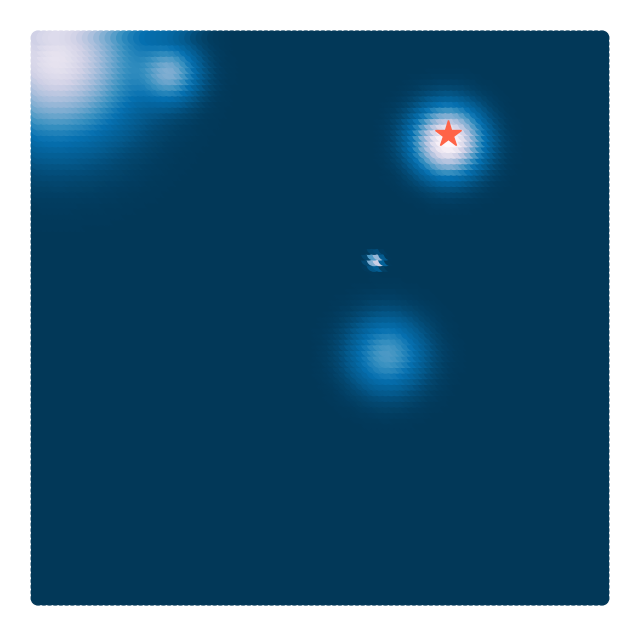

In [4]:
## We have to make a list of points at which to plot the landscape. NumPy's meshgrid is 
## a built-in utility for this purpose. 
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
print(X.shape)
Z = loss(X) # same as loss.loss(X) because class is callable

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(xx.ravel()[Z.argmin()], yy.ravel()[Z.argmin()], '*', markersize=20)
plt.axis('off')

Recall that many optimization routines requre the gradient of the landscape. We can analytically calculate the gradient of this landscape

$$
\mathcal{L} = \sum_{p=1}^P \mathcal{L}_p = -\sum_{p=1}^P A_p \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$

$$
\nabla \mathcal{L} = \sum_{p=1}^P A_p\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})}{\sigma^2} \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$

Recall that while $\mathcal{L}$ is a scalar, $\nabla \mathcal{L}$ is a vector of the same dimension as $\mathbf{x}$. We can implement both the landscape and its gradient within a single loss object. We vectorize the computation of the loss and gradient over the $P$ wells using `np.einsum`

(10000, 2)


(np.float64(-3.3), np.float64(3.3), np.float64(-3.3), np.float64(3.3))

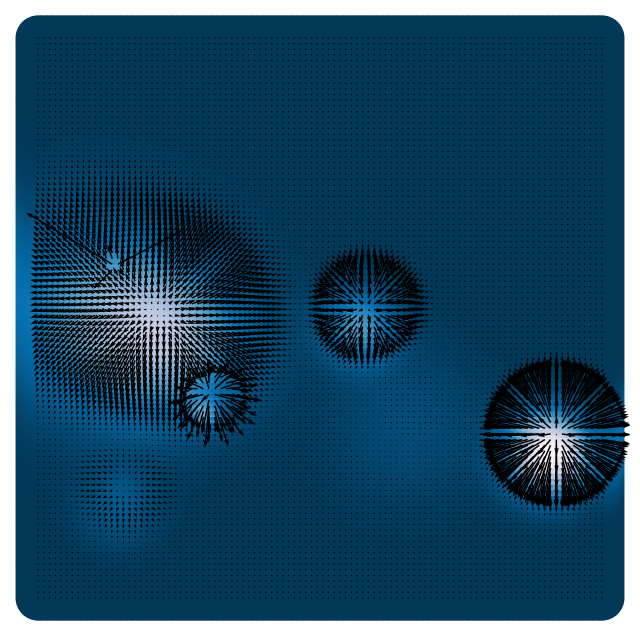

In [5]:
class RandomLossLandscape(RandomLossLandscapeWithoutGradient):
    """
    A random two-dimensional loss landscape with a gradient defined everywhere
    """

    def __init__(self, *args, **kwargs):
        ## Passes all arguments and keyword arguments to the parent class
        super().__init__(*args, **kwargs)

    def _grad_gaussian_well(self, X, width=1):
        return -2 * X / (width ** 2) * self._gaussian_well(X, width)[:, None, :]

    def grad(self, X):
        # Arg shape before summation is (n_batch, n_dim, n_wells)
        return np.sum(
            self.coeffs * self._grad_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), 
            axis=-1
        )

loss = RandomLossLandscape(random_state=None, n_wells=8)

plt.figure(figsize=(8, 8))

## First we plot the scalar field at high resolution
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
print(X.shape)
Z = loss(X) # same as loss.loss(X) because class is callable
plt.scatter(X[:, 0], X[:, 1], c=Z, s=1000)

# x = np.linspace(-3, 3, 15)
# y = np.linspace(-3, 3, 15)
# xx, yy = np.meshgrid(x, y)
# X = np.array([xx.ravel(), yy.ravel()]).T
# Z = loss.loss(X)
plt.quiver(X[:, 0], X[:, 1], loss.grad(X)[:, 0], loss.grad(X)[:, 1], scale=1e1, color='k')
# plt.streamplot(x, y, loss.grad(X)[:, 0].reshape(100, 100), loss.grad(X)[:, 1].reshape(100, 100), color=Z.reshape(100, 100))
plt.axis('off')


# Disordered media and Gaussian Random Fields

The Gaussian mixture we are studying is a toy model for disordered media, because it approximates Gaussian random field (GRF). A GRF is a random function $f(x)$ whose values at any set of points $x_1, x_2, \ldots, x_n$ are jointly Gaussian distributed. This means that the probability distribution for the values of the function at these points is given by a multivariate normal distribution.

Gaussian random fields appear as models in many areas of physics and engineering, including:
- Cosmology: The initial density fluctuations in the early universe are often modeled as a Gaussian random field.
- Geostatistics: GRFs are used to model spatially correlated data, such as the distribution of minerals in the Earth's crust or the variation of soil properties.
- Condensed Matter Physics: GRFs can describe disordered systems, such as spin glasses or random media.

<img src="../resources/maibach_prd_2021.png" style="max-width:40%; height:auto;">

*Gaussian random fields are used to model brightness fluctuations in radio spectrum in models of the early universe. Image from [Maibach et al., Phys. Rev. D (2021)](https://doi.org/10.1103/PhysRevD.104.123535).*

<br><br><br><br><br><br><br><br><br>

## Optimization in complex landscapes

We are interested in finding the minima of a Gaussian random field. In a disordered system like a material, this corresponds to where the system localizes at low temperatures. 

### Some considerations when performing multivariate optimization

+ Having a smooth landscape is important for many optimization algorithms to work well, because gradient information is required for local search methods to update their state in a meaningful way.

+ Because differentiability is a concern, we expect that flatter regions in the landscape will pose challenges. In our Gaussian landscape, the regions far away from the $P$ centers will be flat, and so we expect optimizers initialized in these regions to struggle on this problem.

<br><br><br>

## Computing analytic gradients is hard

+ Computing analytic gradients is hard, and often impossible. We can use finite differences to approximate the gradient along each dimension:

$$
\frac{\partial f}{\partial x_i} \approx \frac{f(x_1, \ldots, x_i + \epsilon, \ldots, x_D) - f(x_1, \ldots, x_i - \epsilon, \ldots, x_D)}{2\epsilon}
$$

+ Finite difference gradients are computationally expensive: In $d$ dimensions, we need to evaluate the function $\mathcal{O}(d)$ times to compute the gradient. This is impractical for high-dimensional problems, but it is acceptable for our 2D landscape.
+ Symbolic gradients are useful, but prone to errors
+ We use a gradcheck function to mitigate the risk of errors in our gradients.
+ (Later in the course): Faster gradient estimation for more complex loss functions with automatic differentiation (the symbolic chain rule for arbitrary compositions of primitive functions).


In [6]:
def gradcheck(loss, x, eps=1e-9):
    """
    This function computes the exact gradient and an approximate gradient using 
    finite differences

    Args:
        loss (callable): loss function. Must have a method `grad` that returns the 
            analytic gradient
        x (np.ndarray): input to the loss function
        eps (float): epsilon for finite differences

    Returns:
        grad (np.ndarray): analytic gradient
        grad_num (np.ndarray): numerical gradient
    
    """
    x = np.array(x)
    grad = loss.grad(x)
    grad_num = list()
    for i in range(x.shape[0]):
        x1, x2 = x.copy(), x.copy()
        x1[i] += eps
        x2[i] -= eps
        grad_num.append((loss(x1) - loss(x2)) / (2 * eps))
    grad_num = np.array(grad_num)
    return grad, grad_num

grad, grad_num = gradcheck(loss, np.random.randn(2))

print(f"True gradient: {grad.squeeze()}\nApproximate gradient: {grad_num.squeeze()}")

print(np.allclose(grad, grad_num, atol=1e-1))

True gradient: [ 0.07939433 -0.0170474 ]
Approximate gradient: [ 0.07939433 -0.0170474 ]
True


# Constrained optimization with projected gradient descent

+ So far, the individual components of our vector $\mathbf{x}$ have been updated independently of each other. They only interact in the sense that both specify the value of the loss function $\mathcal{L}(\mathbf{x})$, at which we compute the gradient.
+ What if we want to impose constraints on the components of $\mathbf{x}$?

Example: The squared elements of $\mathbf{x}$ must sum to one. This is a common constraint when we are optimizing over unit directions in a space, or potentially when we are optimizing over probability distributions.
$$
\sum_i x_i^2 = 1
$$

If we denote the set as $\mathcal{S} = \{ \mathbf{x} \in \mathbb{R}^n : \sum_i x_i^2 = 1 \}$, then we can project a vector $\mathbf{x}$ onto the set by solving the following optimization problem:
$$
\mathbf{x}^* = \arg \min_{\mathbf{x} \in \mathcal{S}} \|\mathbf{x} - \mathbf{x}^*\|^2
$$

## Projected gradient descent

We enforce the constraint by projecting the output gradient descent update rule onto the set at each step
$$
\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}(\mathbf{x})
$$
Followed by projection,
$$
\mathbf{x} \leftarrow \text{Proj}_{\mathcal{S}}(\mathbf{x})
$$

<!-- ## Example: Constrained optimization

+ Consider the problem of minimizing the function
$$
\mathcal{L}(\mathbf{x}) = \frac{1}{2} \mathbf{x}^T \mathbf{A} \mathbf{x} + \mathbf{b}^T \mathbf{x}
$$
subject to the constraint
$$
\mathbf{c}^T \mathbf{x} = 0
$$
where $\mathbf{A}$ is a symmetric positive definite matrix, $\mathbf{b}$ is a vector, and $\mathbf{c}$ is a vector. -->



In [103]:
class ProjectedGradientDescent(BaseOptimizer):
    """A Multivariate Gradient Descent Optimizer"""

    def __init__(self, loss, **kwargs):
        super().__init__(loss, **kwargs)

    def update(self, X):
        self.X = self.project(self.X)
        grad = self.loss.grad(self.X)
        return self.project(X - self.lr * grad)

    def project(self, X):
        """
        Project onto the simplex consisting of points where the norm of all elements is one
        """
        X = X.copy()
        X /= np.linalg.norm(X, axis=1, keepdims=True)
        return X
        

In [104]:
# Initialize optimizer
optimizer = ProjectedGradientDescent(loss, lr=0.1, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3


# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

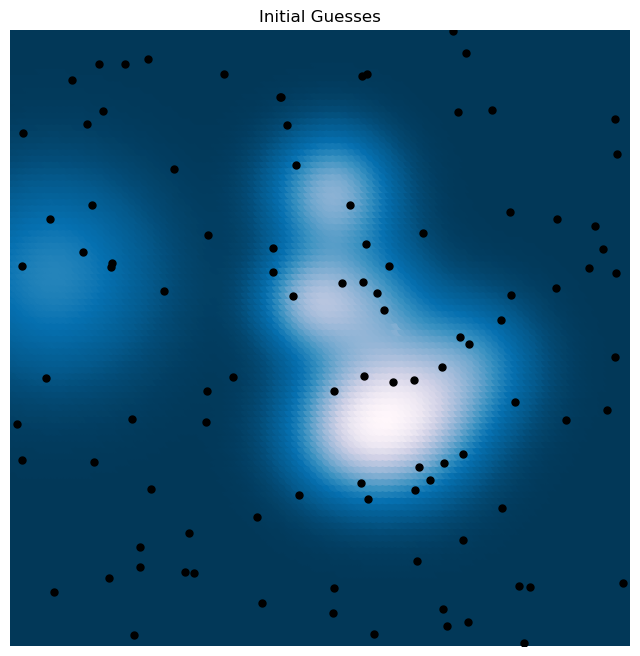

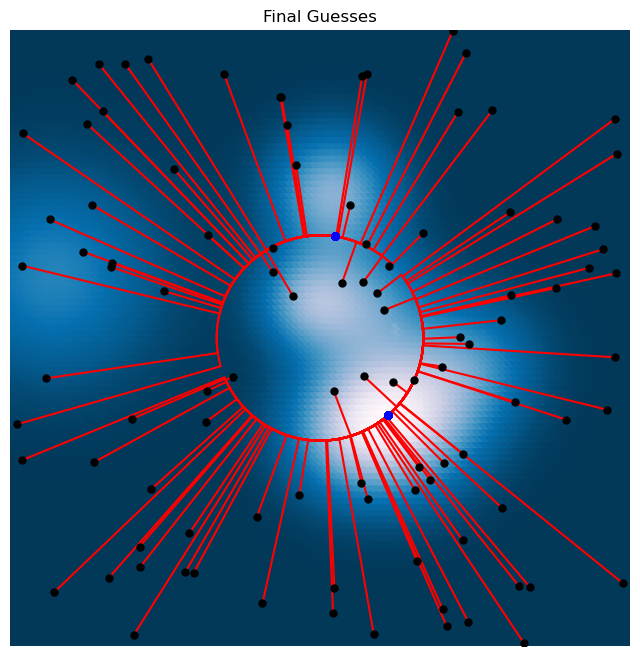

In [105]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r', zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [106]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    # plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    # plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.r');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

### What about inequality constraints? 

+ What if we don't require strictly that the individual elements $x_i$ add up to something, but instead that they are bounded?
+ For example, $\sum_i x_i^2 \leq 1$ or $0 \leq x_i \leq 1$?
+ Where we are constrained to a subdomain, but *not* a subspace. This is the setting for Interior Point methods
+ See the [textbook by Boyd and Vandenberghe](https://web.stanford.edu/~boyd/cvxbook/) for discussion of these methods

# Equality constrained optimization with Lagrange multipliers

+ We can also enforce equality constraints by adding a Lagrange multiplier term to the loss function. For example, for our unit norm constraint, we augment the loss function to the following,
$$
\mathcal{L}^{(a)}(\mathbf{x}, \lambda) = \mathcal{L}(\mathbf{x}) + \lambda \left( \mathbf{x}^T \mathbf{x} - 1 \right)
$$
where $\lambda$ is a Lagrange multiplier.

+ We can then solve the following optimization problem:
$$
\mathbf{x}^* = \arg \min_{\mathbf{x}} \mathcal{L}^{(a)}(\mathbf{x}, \lambda)
$$



+ The solution to this problem is given by the following update rule:
$$
\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}^{(a)}(\mathbf{x}, \lambda)
$$
As well as an update rule for the Lagrange multiplier:
$$
\lambda \leftarrow \lambda + \eta \nabla_\lambda \mathcal{L}^{(a)}(\mathbf{x}, \lambda)
$$
Note that we are doing gradient *ascent* on the Lagrange multiplier, since we don't necessarily want to minimize the function with respect to $\lambda$. This algorithm represents a version of [*Lagrangian duality*](https://people.cs.umass.edu/~domke/courses/sml/07lagrange.pdf).

<br></br>

For our example, we write the gradient of the augmented loss function as
$$
\nabla \mathcal{L}^{(a)}(\mathbf{x}, \lambda) = \mathcal{L}(\mathbf{x}) + \lambda \mathbf{x}
$$
and the gradient of the Lagrange multiplier is
$$
\nabla_\lambda \mathcal{L}^{(a)}(\mathbf{x}, \lambda) = \mathbf{x}^T \mathbf{x} - 1
$$

In [107]:
class GradientDescentLagrange(BaseOptimizer):
    """A Multivariate Gradient Descent Optimize with Lagrange Multipliers"""

    def __init__(self, loss, lam, **kwargs):
        super().__init__(loss, **kwargs)
        self.lam = lam # Lagrange multiplier hyperparameter

    def update(self, X):
        grad = self.loss.grad(X)
        self.lam = self.lam + self.lr * (np.einsum('ij,ij->i', X, X) - 1)
        return X - self.lr * (grad + self.lam[..., None] * X)

    

In [108]:
# Initialize optimizer
optimizer = GradientDescentLagrange(loss, lr=0.1, lam=0.5, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

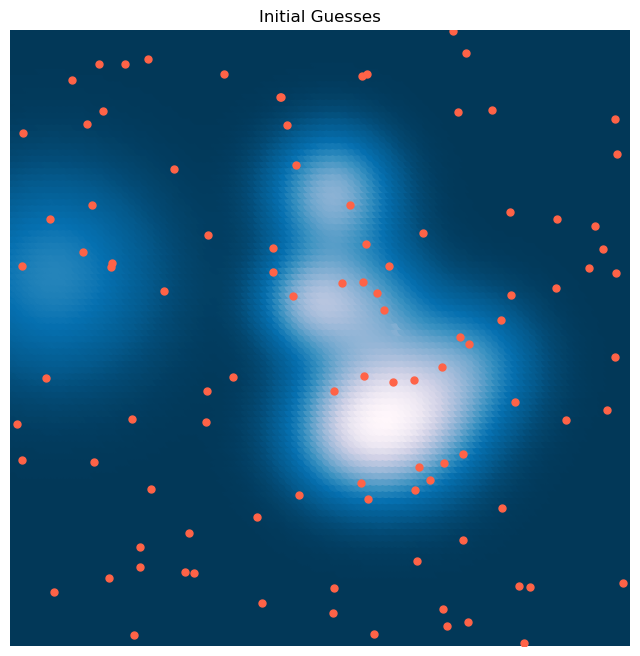

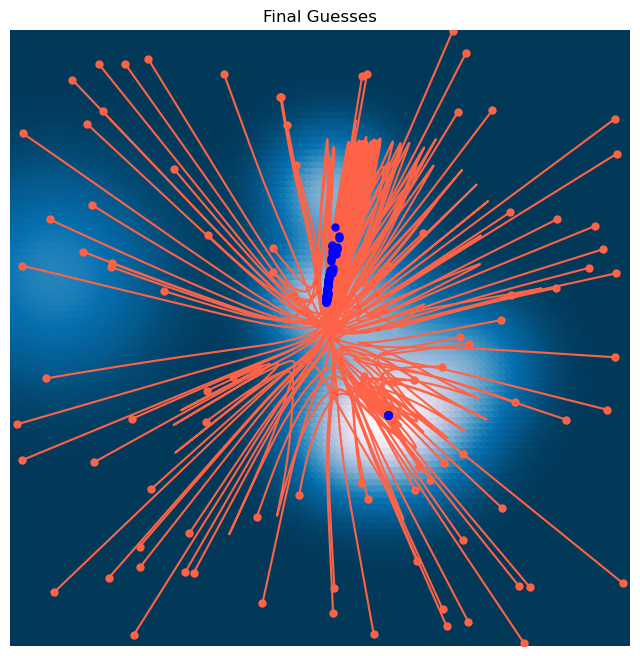

In [111]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [113]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)



def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    # plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    # plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.');
    # unit_circle = np.random.random((2000, 2)) - 0.5
    # unit_circle = unit_circle / np.linalg.norm(unit_circle, axis=1, keepdims=True)
    # plt.plot(*unit_circle.T, '.k', markersize=0.5)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

## First-order methods widely-used today

+ Stochastic gradient descent remains suprisingly effective. Remember that the stochasticity in ML comes from approximating our loss landscape from a subset of the data, not from the noise term in the update rule
+ Adam, Adagrad, RMSprop, etc. are all variants of stochastic gradient descent. We track gradients over time, and use them to adapt the learning rate and gradient in various ways. 

# Second order methods

So far, we have only been using methods in which we take the first derivative of the loss function. As we saw in the 1D case, we can converge much faster by using information from the second derivative of the loss function to adjust our learning rate.

For a loss function $\mathcal{L}(\mathbf{x}) \in \mathbb{R}$ computed at location $\mathbf{x} \in \mathbb{R}^d$, the second derivative is given by the Hessian matrix, $\mathbf{H} = \nabla^2 \mathcal{L}(\mathbf{x}) \in \mathbb{R}^{d \times d}$

Writing this out in matrix form, we have
$$
\mathbf{H} = \begin{bmatrix}
\frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_1^2} & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_1 \partial x_d} \\
\frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_2 \partial x_1} & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_2^2} & \cdots & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_2 \partial x_d} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_d \partial x_1} & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_d \partial x_2} & \cdots & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_d^2}
\end{bmatrix}
$$

Recalling our intuition from the 1D case, we can see that the Hessian matrix is a measure of how steeply curved the loss function appears at a given point. If the Hessian is positive definite, then the loss function is locally convex, and we can use the second derivative to adjust our learning rate.

<br><br><br><br>


## The Hessian of the Random Gaussian well landcape

Recall that our test landscape is a sum of Gaussian wells,
$$
\mathcal{L} = \sum_{p=1}^P \mathcal{L}_p = -\sum_{p=1}^P A_p \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$
where $\mathbf{x} \in \mathbb{R}^d$ is the location in the landscape, $\boldsymbol{\mu}_p \in \mathbb{R}^d$ is the center of the $p$th well, and $\sigma$ is the width of the well.

The gradient of the loss function is given by
$$
\nabla \mathcal{L} = \sum_{p=1}^P A_p\exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right) \frac{(\mathbf{x} - \boldsymbol{\mu}_{p})}{\sigma^2}
$$

The Hessian matrix is given by
$$
\mathbf{H} = \sum_{p=1}^P A_p \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right) \left(\frac{1}{\sigma^2} \mathbf{I} - \frac{(\mathbf{x} - \boldsymbol{\mu}_{p})(\mathbf{x} - \boldsymbol{\mu}_{p})^T}{\sigma^4}\right)
$$
Note the order of the last product, which is an outer product and not a contracting inner product. We add this derived implementation of the Hessian matrix to our loss object using subclassing.

In [73]:
class RandomLossLandscapeWithHessian(RandomLossLandscape):
    """
    Subclass of the Random Gaussian Loss Landscape that adds an analytic Hessian calculation
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Everything is passed to the RandomLossLandscape constructor

    def _hessian_gaussian_well(self, X, width=1):
        oprod = np.einsum('ijk,imk->ijmk', X, X) # (n, d, d, 1)
        iden = np.eye(X.shape[1])[None, ..., None] 
        return (-iden + oprod / width**2) / width**2 * self._gaussian_well(X, width)[:, None, None, :]

    def hessian(self, X): 
        return np.einsum('...i,i->...', self._hessian_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), self.coeffs)

loss = RandomLossLandscapeWithHessian(random_state=0, n_wells=8)

(np.float64(-3.3), np.float64(3.3), np.float64(-3.3), np.float64(3.3))

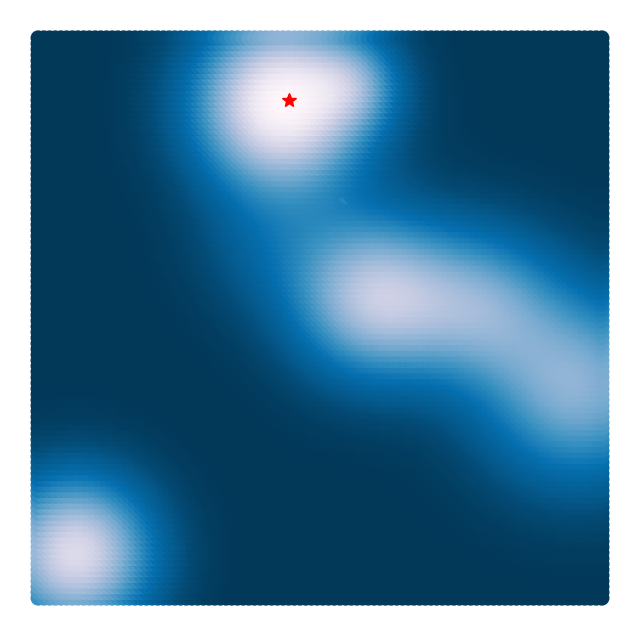

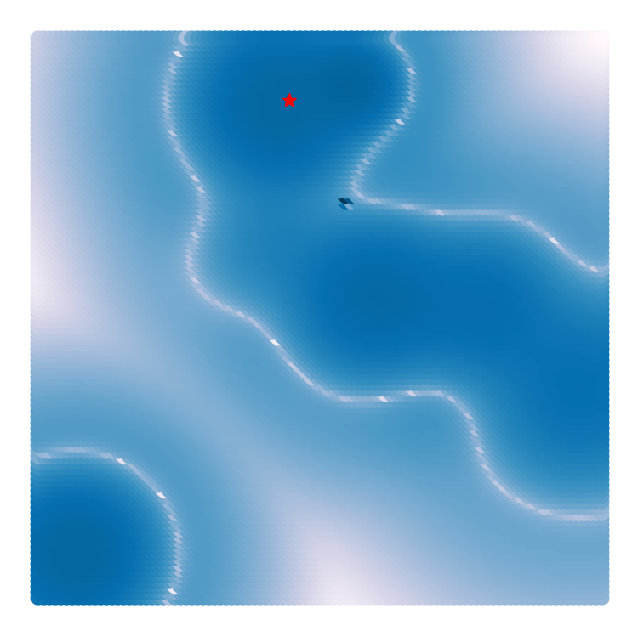

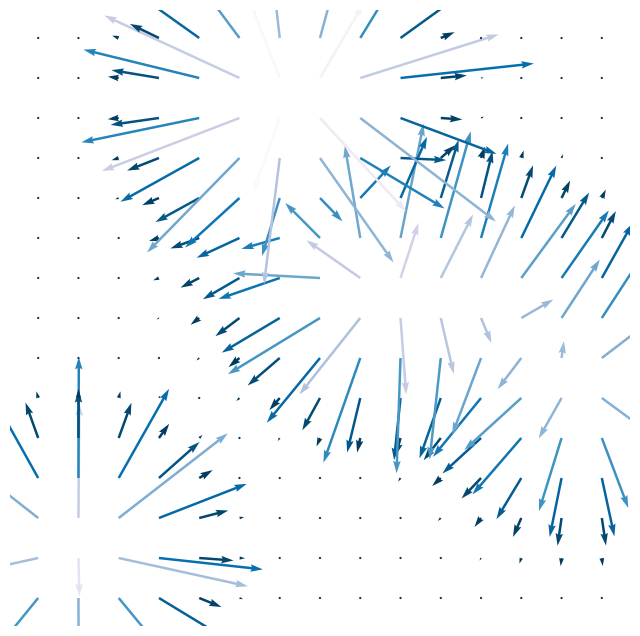

In [74]:

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss(X) # same as loss.loss(X) because class is callable

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(xx.ravel()[Z.argmin()], yy.ravel()[Z.argmin()], '*r', markersize=10)
plt.axis('off')

plt.figure(figsize=(8, 8))
eig_dirs = np.linalg.eigvalsh(loss.hessian(X))
signed_log = lambda x: np.sign(x) * np.log(1 + np.abs(x))
plt.scatter(X[:, 0], X[:, 1], c=np.log10(np.abs(np.mean(eig_dirs, axis=1))))
plt.plot(xx.ravel()[Z.argmin()], yy.ravel()[Z.argmin()], '*r', markersize=10)
plt.axis('off')

plt.figure(figsize=(8, 8))
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)
plt.quiver(X[:, 0], X[:, 1], loss.grad(X)[:, 0], loss.grad(X)[:, 1], Z, scale=1e0)
# plt.streamplot(x, y, loss.grad(X)[:, 0].reshape(100, 100), loss.grad(X)[:, 1].reshape(100, 100), color=Z.reshape(100, 100))
plt.axis('off')

## The multivariate Newton's method

Recall that, in one dimension, Newton's method had the simple form,
$$
    x_{t+1} = x_t - \frac{f'(x_t)}{f''(x_t)}
$$

In higher dimensions, the equivalent of the second derivative is the full $D \times D$ Hessian matrix. The update rule is given by
$$
    \mathbf{x} \leftarrow  \mathbf{x} - \mathbf{H}^{-1} \nabla \mathcal{L}(\mathbf{x}_t)
$$
We can interpret this as (1) scaling the size of a gradient descent step by the curvature of the loss function, and (2) rotating the step to align with the eigenvectors of the Hessian matrix. Aligning with the eigenvectors of the Hessian results in straighter paths to the minimum.

We can also add a damping hyperparameter $\alpha$ in the update rule, which slows down the rate of convergence but can help with stability.
$$
    \mathbf{x} \leftarrow  \alpha \mathbf{x} - (1 - \alpha) \mathbf{H}^{-1} \nabla \mathcal{L}(\mathbf{x}_t)
$$


In [127]:
class MultivariateNewtonsMethod:
    """
    Optimize a function, subject to the constraint that the solution lies in a convex set.
    """
    
    def __init__(self, loss,  max_iter=1000, tol=1e-6, damping=0.9, lr=None, random_state=None, store_history=False):
        self.loss = loss
        self.max_iter = max_iter
        self.tol = tol
        self.damping = damping
        self.random_state = random_state
        np.random.seed(random_state)
        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def fit(self, X):
        
        self.X = X
        if self.store_history:
            self.Xs = [self.X.copy()]
            self.losses = [self.loss(X)]

        for i in range(self.max_iter):

            ## compute the gradient and the Hessian
            ## adding a small diagonal term to the Hessian helps with numerical stability
            grad = self.loss.grad(self.X)
            hess = self.loss.hessian(self.X) + 1e-12 * np.eye(self.X.shape[1])[None, ...]
            
            ## Invert the Hessian
            ihess = np.linalg.inv(hess)

            ## Because we only want to operate on the last axis, we need to use einsum
            self.X -= np.einsum('ink,ik->in', ihess, grad, optimize=True)

            ## momentum
            # self.X = self.damping * self.X - (1 - self.damping) * np.einsum('ink,ik->in', ihess, grad, optimize=True)

            if self.store_history:
                self.Xs.append(self.X.copy())
                self.losses.append(self.loss(self.X))

            # Stop early if loss is not decreasing any more for *any* batch elements
            if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
                break

In [95]:
# Initialize optimizer
optimizer = MultivariateNewtonsMethod(loss, max_iter=1000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3
# X0 = np.random.random(size=(100, 2))

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

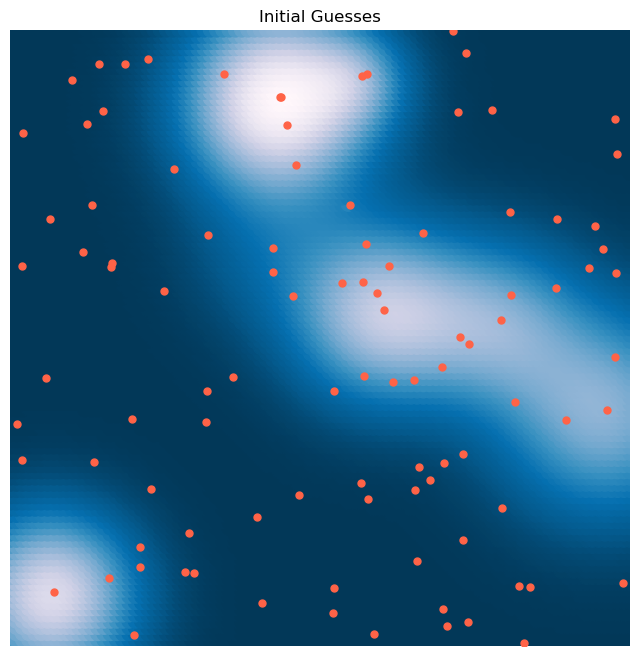

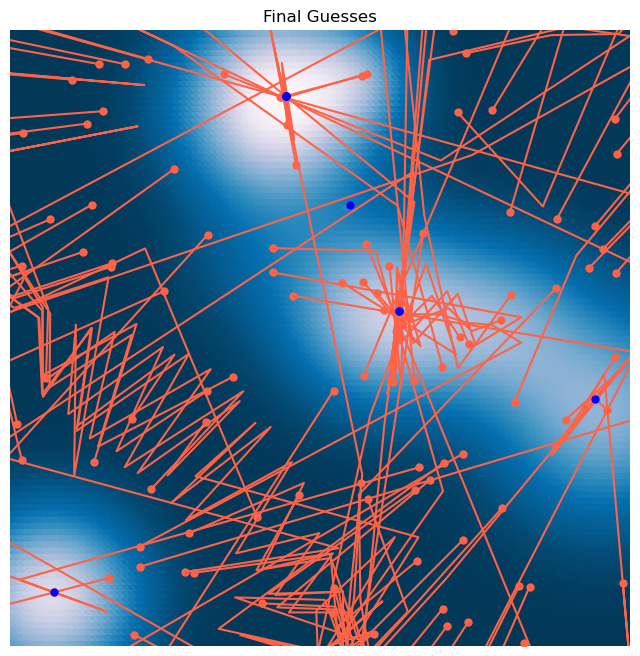

In [96]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

Text(0, 0.5, 'Loss')

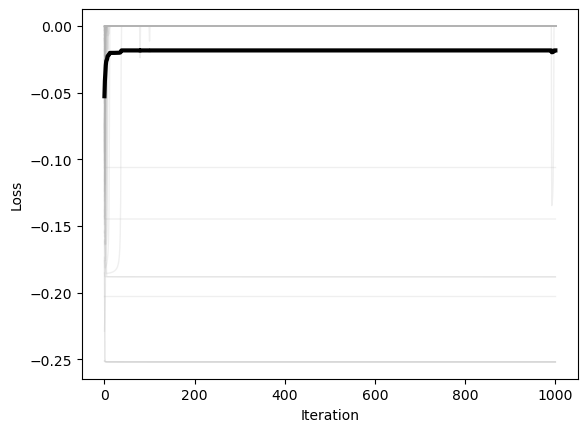

In [97]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


In [149]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    # plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    # plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=929), Output()), _…

<function __main__.plotter(i)>

## The results are underwhelming

The Newton method acts weird because our objective function is non-convex, so convergence is not guaranteed. Notice that points close to wells quickly converge; it's the points in between wells that have trouble. That's because these are flat regions with extremely low curvature, and so the inverse Hessian is extremely large.

The Hessian matrix is not positive definite in some regions, so we usually can't use Newton's method for non-convex functions. Instead, we can use quasi-Newton methods, which use second-order information. Many of these methods also aim to avoid the computational expense of building and inverting the full $D \times D$ Hessian matrix.

<br><br><br><br><br><br>

## The spectrum of the Hessian


The eigenvalues of the Hessian matrix are a measure of how steeply the loss function changes in each direction. For a harmonic potential, they give us the stiffness of the potential in each direction. We can Taylor expand the potential around a given point $\mathbf{x}$, relative to a nearby point $\mathbf{x}'$
$$
    \mathcal{L}(\mathbf{x}) \approx \mathcal{L}(\mathbf{x'}) + \nabla \mathcal{L}(\mathbf{x'})^T (\mathbf{x} - \mathbf{x'}) + \frac{1}{2} (\mathbf{x} - \mathbf{x'})^T \mathbf{H}(\mathbf{x'}) (\mathbf{x} - \mathbf{x'}) + ...
$$
where we assume that $\mathbf{x} - \mathbf{x'}$ is a small displacement. If $\mathbf{x} - \mathbf{x'}$ is aligns with one of the eigenvector axes of a multivariate harmonic potential, then the second term in the Taylor expansion is directly proportional to the eigenvalue associated with that direction.

Because different directions in a multivariate potential have different stiffnesses, the Hessian has distinct eigenvalues, so the relative size of the second term depends on the direction of the displacement $\mathbf{x} - \mathbf{x'}$.For very oblong potentials, the difference along various directions can be dramatic. This can be quantified by condition number, or the the ratio of the largest to smallest eigenvalue: $$ {\displaystyle \kappa (H)={\frac {\left|\lambda _{\text{max}}(H)\right|}{\left|\lambda _{\text{min}}(H)\right|}},} $$

Optimally, we'd have a separate learning rate for each direction in space, but this becomes computationally expensive in high dimensions. Instead, we can use the condition number to adapt the learning rate.
$$
    \mathbf{x} \leftarrow \mathbf{x} - \frac{\eta}{\kappa(\mathbf{H}) + \epsilon} \nabla \mathcal{L}(\mathbf{x})
$$
where $\eta$ is the initial learning rate, $\kappa(\mathbf{H})$ is the condition number of the Hessian matrix, and $\epsilon$ is a small constant to prevent division by zero.


Another option is to adjust learning rate based only the largest Hessian eigenvalue (we can use the power method to find this quickly in $O(D^2)$ operations, without having to find the full spectrum ($O(D^3)$) or invert the Hessian matrix ($O(D^3)$))
$$
    \mathbf{x} \leftarrow \mathbf{x} - \frac{\eta}{\lambda_{\text{max}}} \nabla \mathcal{L}(\mathbf{x})
$$
where $\lambda_{\text{max}}$ is the largest eigenvalue of the Hessian matrix. We could also adjust the learning rate based on the sum of the largest and smallest eigenvalues of the Hessian matrix.
$$
\mathbf{x} \leftarrow \mathbf{x} - \frac{\eta}{|\lambda_{\text{max}|} + |\lambda_{\text{min}}|} \nabla \mathcal{L}(\mathbf{x})
$$
we can usually find the largest eigenvalue quickly using the power method, and the smallest eigenvalue using another iterative method, [inverse iteration](https://en.wikipedia.org/wiki/Inverse_iteration).

In [99]:
class GradientDescentAdaptive(BaseOptimizer):
    """
    Optimize a function, subject to the constraint that the solution lies in a convex set.
    """
    
    def __init__(self, loss, **kwargs):
        super().__init__(loss, **kwargs)

    def update(self, X):
        grad = self.loss.grad(self.X)
        hess = self.loss.hessian(self.X) + 1e-12 * np.eye(self.X.shape[1])[None, ...]
        scale = np.abs(np.linalg.eigh(hess)[0][-1]) # + np.abs(np.linalg.eigh(hess)[0][0])
        return X - self.lr * grad / scale

Text(0, 0.5, 'Loss')

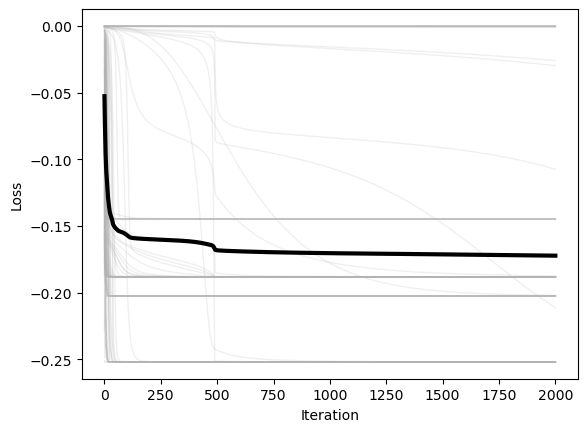

In [112]:
# Initialize optimizer
optimizer = GradientDescentAdaptive(loss, lr=1e-3, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer"
optimizer.fit(X0.copy())

plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Final Guesses')

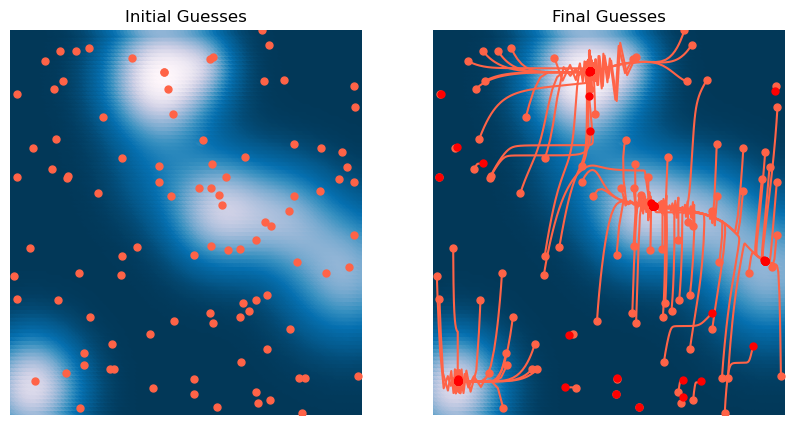

In [113]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.subplot(1, 2, 2)
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.r', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [117]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    plt.plot(Xs[:i, :, 0], Xs[:i, :, 1]);
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

## Quasi-Newton methods

Creating the Hessian matrix is computationally expensive in high dimensions, requiring at least $O(D^2)$ operations and $O(D^2)$ memory. Inverting it is even worse, requiring ($O(D^3)$ operations).

We can reduce this cost by approximating the Hessian matrix with a low-rank approximation. Recall that we can write a matrix $H \in \mathbb{R}^{D \times D}$ as $H = Q \Lambda Q^T$, where $Q \in \mathbb{R}^{D \times D}$ is an orthonormal matrix of eigenvectors and $\Lambda \in \mathbb{R}^{D \times D}$ is a diagonal matrix of eigenvalues. We can also truncate the $Q$ matrices to a low-rank approximation $\tilde{A} \in \mathbb{R}^{D \times D}$, where $\tilde{A} \approx Q_k \Lambda_k Q_k^T$, where $Q_k \in \mathbb{R}^{D \times k}$ and $\Lambda_k \in \mathbb{R}^{k \times k}$ are the first $k$ columns of $Q$ and the first $k$ diagonal elements of $\Lambda$, respectively.

Another popular algorithm is L-BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm). This uses an iterative method to approximate the inverse Hessian matrix directly at each step.

In [ ]:
class LBFGS(BaseOptimizer):

    def __init__(self, loss, memory=10, **kwargs):
        super().__init__(loss, **kwargs)
        self.memory = memory
        self.grad_hist = []  # Gradient history
        self.s_hist = []     # Steps history

    def update(self, X):
        grad = self.loss.grad(X)
        s, y = None, None
        if len(self.grad_hist) > 0:
            s = X - self.X_prev  # Step taken
            y = grad - self.grad_prev  # Change in gradient

            if len(self.grad_hist) >= self.memory:
                self.grad_hist.pop(0)
                self.s_hist.pop(0)

            self.grad_hist.append(y)
            self.s_hist.append(s)

        Hk = self.get_inverse_hessian_approximation()
        pk = -Hk.dot(grad)

        self.X_prev = X.copy()
        self.grad_prev = grad.copy()

        return X + self.lr * pk

    def get_inverse_hessian_approximation(self):
        """
        Compute the approximate inverse Hessian matrix.
        Uses the LBFGS algorithm's update rules.
        """
        H0 = np.eye(len(self.X))  # Initial approximation (identity matrix)

        # Apply the LBFGS update formula using the history
        for i in range(len(self.s_hist) - 1, -1, -1):
            s = self.s_hist[i]
            y = self.grad_hist[i]
            rho = 1.0 / (y @ s)

            if i == len(self.s_hist) - 1:
                # Scale the initial Hessian approximation (H0)
                gamma = (s @ y) / (y @ y)
                H0 = gamma * H0

            Hs = H0 @ s
            H0 = H0 + np.outer(y, y) * rho * rho - (np.outer(Hs, s) + np.outer(s, Hs)) * rho

        return H0

Text(0, 0.5, 'Loss')

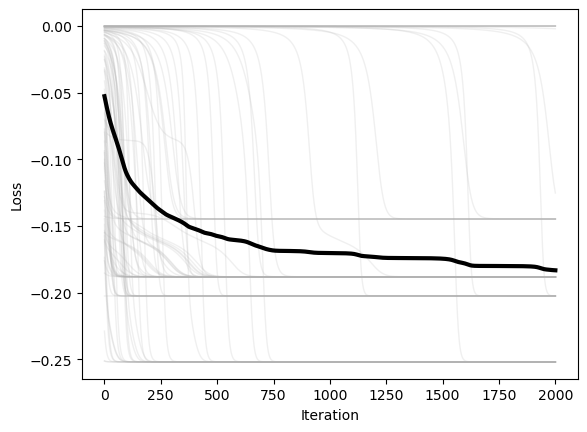

In [121]:

loss = RandomLossLandscapeWithHessian(random_state=0, n_wells=8)

# Initialize optimizer
optimizer = LBFGS(loss, lr=0.1, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())


plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Final Positions')

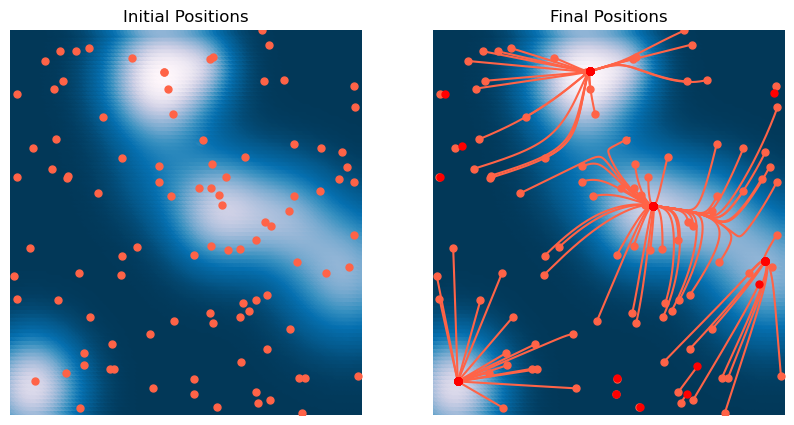

In [124]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Positions')

plt.subplot(1, 2, 2)
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.r', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Positions')

## A bakeoff: Which method is the best?

We can compare the performance of the different methods we've seen so far. We compute two metrics: the final loss value, and the total amount of walltime required to reach that loss value. A more accurate measure of performance might count individual operations and memory usage, rather than aggregate walltime, but the walltime should give us an idea of the tradeoffs involved.

In [128]:
import time

## Set up our loss function and initial conditions
loss = RandomLossLandscapeWithHessian(random_state=0, n_wells=8)
X0 = 6 * np.random.random(size=(500, 2)) - 3

## Set our optimizers and hyperparameters
optimizer_kwargs = {"max_iter": 5000, "lr": 0.1, "tol": 1e-6, "random_state": 0, "store_history": True}
optimizer_list = [
    GradientDescent(loss, **optimizer_kwargs),
    GradientDescentMomentum(loss, **optimizer_kwargs),
    StochasticGradientDescent(loss, noise=0.2, **optimizer_kwargs),
    MultivariateNewtonsMethod(loss, **optimizer_kwargs),
    GradientDescentAdaptive(loss, **optimizer_kwargs),
    LBFGS(loss, **optimizer_kwargs),
]

all_losses = []
all_walltimes = []

for optimizer in optimizer_list:
    
    start_time = time.time()
    optimizer.fit(X0.copy())
    stop_time = time.time()

    final_loss = np.mean(optimizer.losses, axis=1)[-1]
    
    all_losses.append(final_loss)
    all_walltimes.append(stop_time - start_time)
all_losses = np.array(all_losses)
all_walltimes = np.array(all_walltimes)
optimizer_names = np.array([type(o).__name__ for o in optimizer_list])

Text(0, 0.5, 'Wall Time')

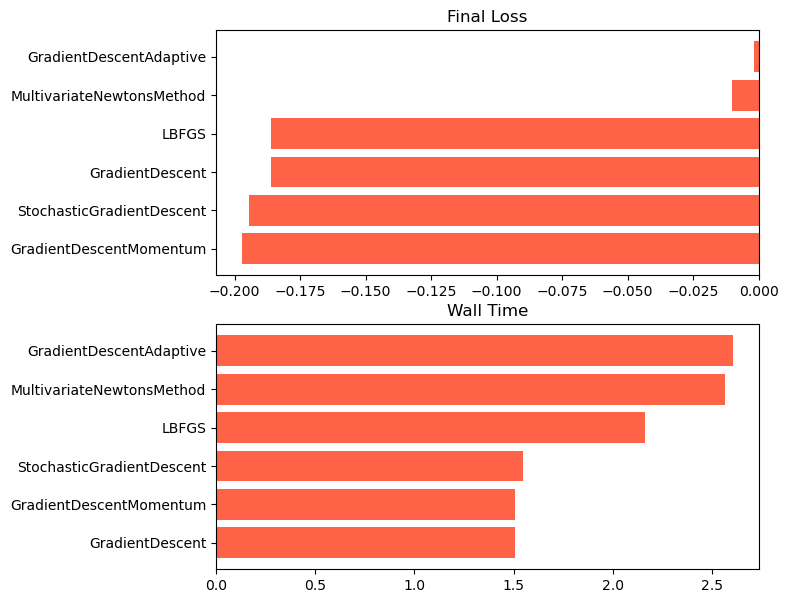

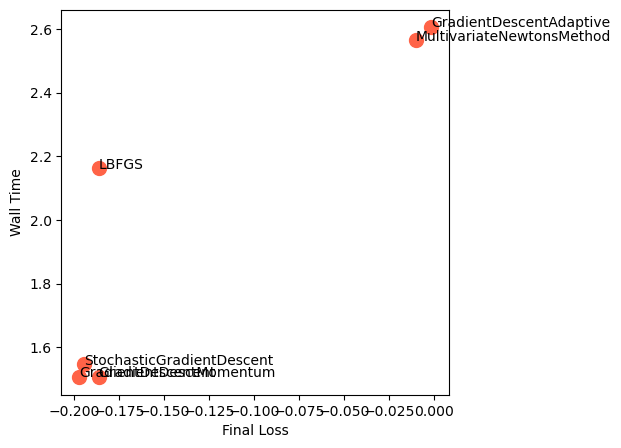

In [135]:
plt.figure(figsize=(7, 7))
sorted_losses = np.argsort(all_losses)
plt.subplot(2, 1, 1)
plt.barh(optimizer_names[sorted_losses], all_losses[sorted_losses])
plt.title('Final Loss')

plt.subplot(2, 1, 2)
sorted_times = np.argsort(all_walltimes)
plt.barh(optimizer_names[sorted_times], all_walltimes[sorted_times])
plt.title('Wall Time')

plt.figure(figsize=(5, 5))
plt.scatter(all_losses, all_walltimes)
## label optimizers
for i in range(len(optimizer_names)):
    plt.annotate(optimizer_names[i], (all_losses[i], all_walltimes[i]))
plt.xlabel('Final Loss')
plt.ylabel('Wall Time')


We can see that, for our non-convex two-dimensional landscape, the lightweight gradient-descent methods are the fastest and most accurate. However, we expect that our results might change on landscapes with rougher curvature, more local minima or saddle points, or higher dimensionality.

<br><br><br><br><br><br>

## What to do without any derivative functions?

All of our optimization methods required us to analytically compute the gradient and Hessian matrix. We did this analytically for the random Gaussian loss landscape, but this is not always feasible for arbitrary landscapes, like the loss functions of deep neural networks, which consist of many nonlinear transformations of the input.

One option is to use finite-difference derivatives, which approximate the gradient and Hessian matrix by taking an initial state vector $\mathbf{x}$ and estimating how $\mathcal{L}(\mathbf{x})$ changes when we perturb $\mathbf{x}$ by a small amount in each of the $D$ dimensions. However, the cost of this approach is $O(D)$ operations to find the gradient, and $O(D^2)$ operations to find the Hessian matrix.

There's another way to compute derivatives that is both exact and fast in high dimensions, called automatic differentiation. Conceptually, when we compute our random Gaussian landscape, we build a series of matrices and then multiply and contract them to obtain a final scalar loss. In automatic differentiation, we store the results of these intermediate calculations when we first compute the loss, a step known as the forward pass. Then, in order to compute the gradient, we can combine these intermediate values in a different order, a step known as the backward pass. This is a consequence of the chain rule for derivatives.

<br><br><br><br><br><br><br><br><br><br><br><br>
